In [1]:
from os.path import expanduser
import sys
motornet_home = expanduser("~") + "/MotorNet"
sys.path.append(motornet_home)

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import motornet as mn
import plg_tasks

# Disable all GPUS
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'
from motornet.plants.muscles import RigidTendonHillMuscleThelen

%load_ext autoreload
%autoreload 2

In [3]:
# SET UP PLANT
plant = mn.plants.RigidTendonArm26(muscle_type=RigidTendonHillMuscleThelen(), visual_delay=0.07, proprioceptive_delay=0.02)

# SET UP NETWORK
n_units = 128
network = mn.nets.layers.GRUNetwork(plant=plant, n_units=n_units, kernel_regularizer=1e-7, name='network', recurrent_regularizer=1e-5)

# SET UP TASK
start_joint_position = [0.785, 1.570] # [45,90] deg
go_cue_range = [.100, .400]
task = plg_tasks.CentreOutReachFF(network=network, start_joint_position=start_joint_position, go_cue_range=go_cue_range)
task.network.do_recompute_inputs = True
task.network.recompute_inputs = task.recompute_inputs
task.loss_weights['cartesian position'] = 0.5
task.loss_weights['muscle state'] = 10.0

rnn = tf.keras.layers.RNN(cell=network, return_sequences=True, name='RNN')

input_dict = task.get_input_dict_layers()
state0 = task.get_initial_state_layers()
states_out = rnn(input_dict, initial_state=state0)

nn = mn.nets.MotorNetModel(inputs=[input_dict, state0], outputs=states_out, name='model', task=task)
nn.compile(optimizer=tf.optimizers.Adam(clipnorm=1.), loss=task.losses, loss_weights=task.loss_weights)

2022-03-26 09:53:08.352554: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
nn.task.get_losses()

[{'joint position': None,
  'cartesian position': <motornet.nets.losses.PositionLoss at 0x7fbe7c62b2e0>,
  'muscle state': <motornet.nets.losses.L2xDxActivationLoss at 0x7fbe7c62b2b0>,
  'geometry state': None,
  'proprioceptive feedback': None,
  'visual feedback': None,
  'excitation': None,
  'gru_hidden0': <motornet.nets.losses.L2xDxRegularizer at 0x7fbe7c62b340>},
 {'joint position': 0.0,
  'cartesian position': 0.5,
  'muscle state': 10.0,
  'geometry state': 0.0,
  'proprioceptive feedback': 0.0,
  'visual feedback': 0.0,
  'excitation': 0.0,
  'gru_hidden0': 0.1}]

In [5]:
# SET UP FFs
b = 8
FF_NF  = tf.convert_to_tensor(np.array([[0, 0],[ 0,0]]), dtype=tf.float32)
FF_CCW = tf.convert_to_tensor(np.array([[0,-b],[ b,0]]), dtype=tf.float32)
FF_CW  = tf.convert_to_tensor(np.array([[0, b],[-b,0]]), dtype=tf.float32)


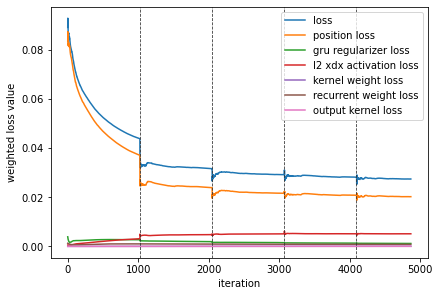

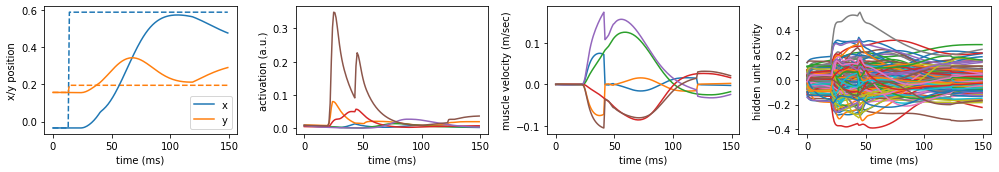

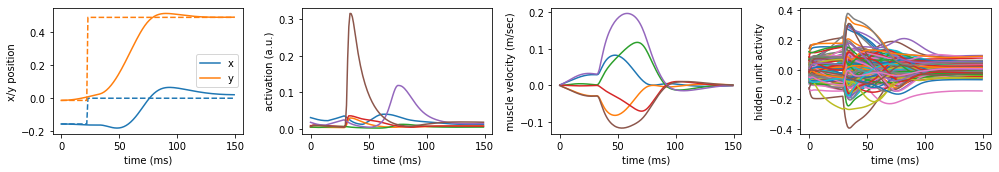

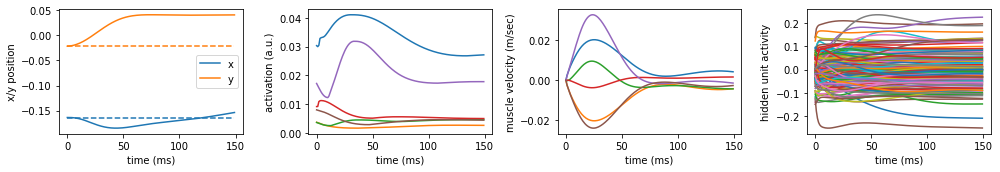

1024/1024 [==============================] - 182s 175ms/step - loss: 0.0275 - position_loss: 0.0407 - gru_regularizer_loss: 0.0117 - l2_xdx_activation_loss: 5.0932e-04


In [6]:
# TRAIN NETWORK on point to point reaches between random targets in the arm's workspace
# IN A NULL FIELD

FF = FF_NF

n_t = 150
n_batches = 1024
batch_size = 64
# this callback logs training information for each batch passed, rather than for each epoch.
callbacks = [mn.nets.callbacks.BatchLogger(), mn.nets.callbacks.TrainingPlotter(task, plot_freq=256, plot_trials=3, plot_n_t=n_t)]
for i in range(5):
    [inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=n_batches * batch_size)
    nn.task.FF_matvel = FF
    h = nn.fit(x=[inputs, init_states], y=targets, verbose=1, epochs=1, batch_size=batch_size, shuffle=False, callbacks=callbacks)

In [7]:
def hand_to_joints(xy, L1, L2):
      j = np.zeros(np.shape(xy))
      j[:,:,1] = np.arccos((xy[:,:,0]**2 + xy[:,:,1]**2 - L1**2 - L2**2) / (2*L1*L2))
      j[:,:,0] = np.arctan2(xy[:,:,1],xy[:,:,0]) - np.arctan2(L2*np.sin(j[:,:,1]),L1+(L2*np.cos(j[:,:,1])))
      return j

def plot_simulations(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure()
  plotor(xy)
  plt.scatter(target_x, target_y)
  plt.xlabel("X (m)")
  plt.ylabel("Y (m)")
  plt.show()

def plot1trial(inputs, results, targets_j, trial=0):
    j_results = results['joint position']
    m_results = results['muscle state']

    plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

    plt.subplot(141)
    plt.plot(j_results[trial, :, 0]*180/np.pi, label='sho')
    plt.plot(j_results[trial, :, 1]*180/np.pi, label='elb')
    plt.plot(targets_j[trial, :, 0]*180/np.pi, '--')
    plt.plot(targets_j[trial, :, 1]*180/np.pi, '--')
    plt.axvline(np.where(inputs["inputs"][trial, :, -1] != 1)[0][0] - network.visual_delay, c='grey')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle (deg)')

    plt.subplot(142)
    plt.plot(j_results[trial, :, 2], label='sho')
    plt.plot(j_results[trial, :, 3], label='elb')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle velocity (rad/sec)')

    plt.subplot(143)
    plt.plot(m_results[trial, :, 0, :])
    plt.xlabel('time (ms)')
    plt.ylabel('activation (a.u.)')
    plt.legend(["PEC","DEL","BRA","TRI","BIC","TR2"], loc=1)

    plt.subplot(144)
    plt.plot(m_results[trial, :, -1, :])
    plt.xlabel('time (ms)')
    plt.ylabel('force (N)')
    plt.legend(["PEC","DEL","BRA","TRI","BIC","TR2"], loc=1)

    plt.show()

plotor = mn.utils.plotor.plot_pos_over_time


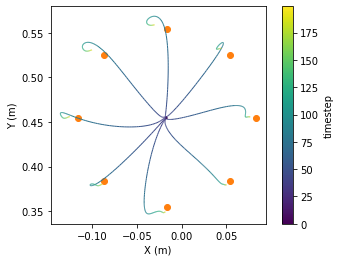

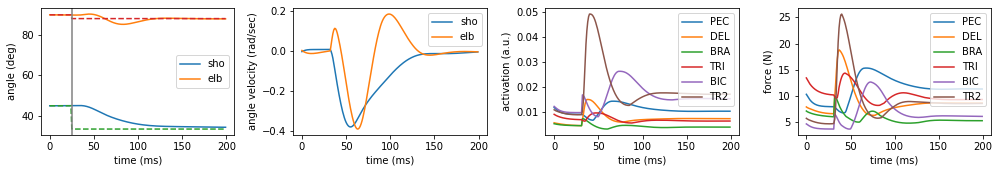

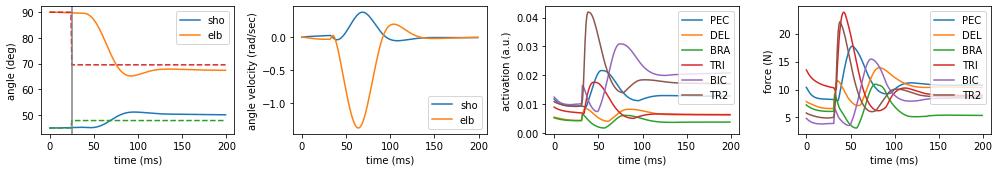

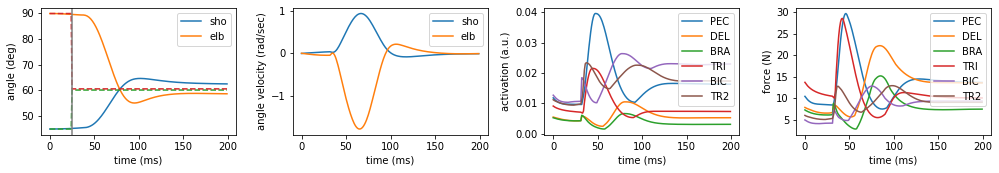

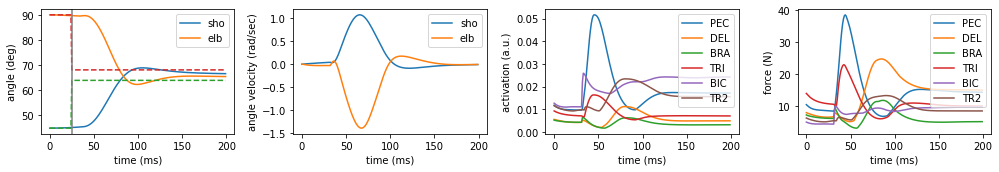

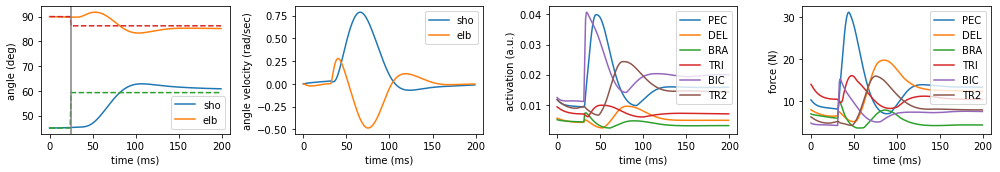

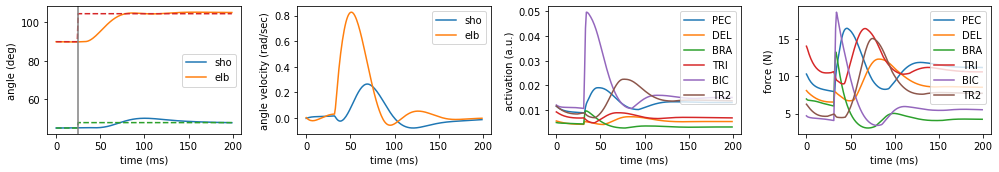

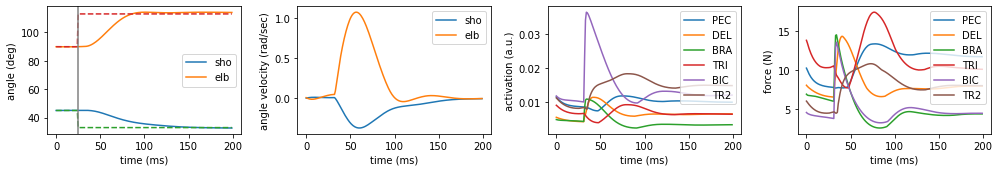

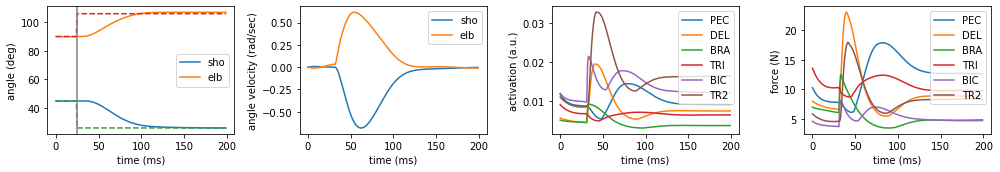

In [8]:
# TEST THE NETWORK ON THE CENTRE-OUT REACHING TASK
# IN A NULL FIELD

FF = FF_NF

n_t = 200
nn.task.angle_step = 45
[inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=8, centre_out_test=True)
nn.task.FF_matvel = FF
results = nn([inputs, init_states], training=False)

plot_simulations(xy=results["cartesian position"], target_xy=targets)

L1,L2 = nn.task.network.plant.skeleton.L1, nn.task.network.plant.skeleton.L2
targets_j = hand_to_joints(targets, L1, L2)
n_mov = np.shape(results["joint position"])[0]
for i in range(n_mov):
    plot1trial(inputs, results, targets_j, i)

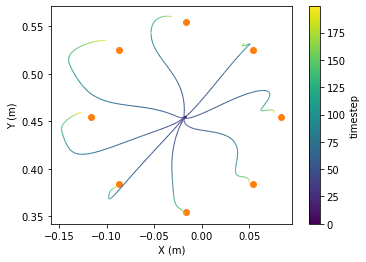

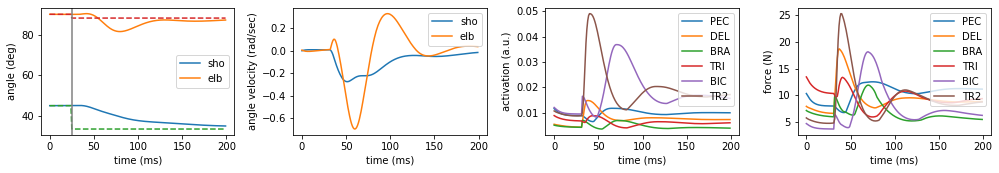

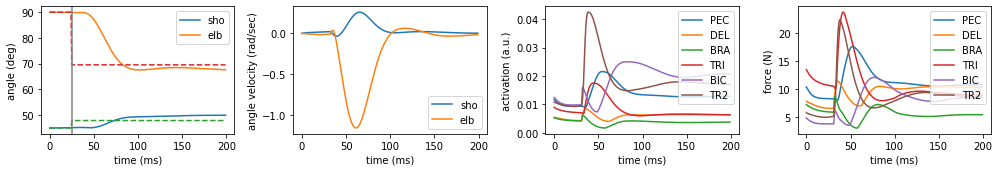

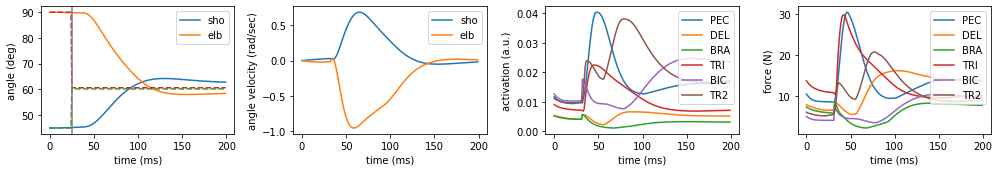

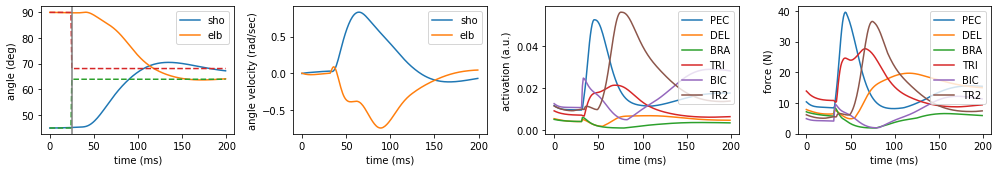

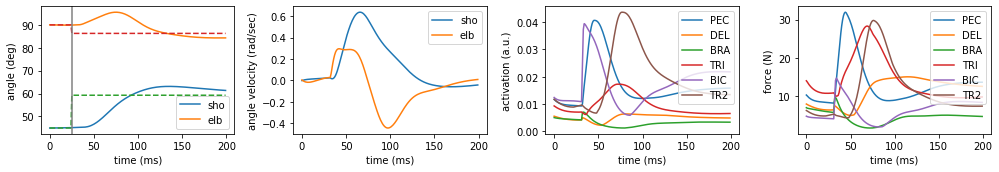

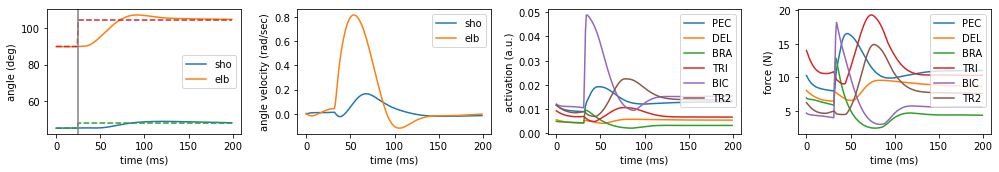

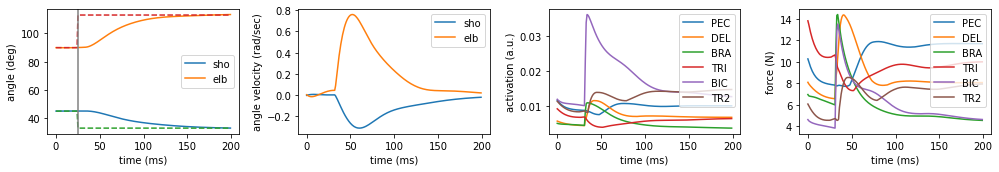

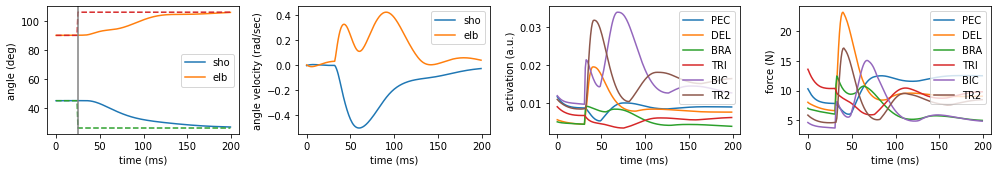

In [9]:
# TEST THE NETWORK ON THE CENTRE-OUT REACHING TASK
# IN A CCW CURL FIELD

FF = FF_CCW

n_t = 200
nn.task.angle_step = 45
[inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=8, centre_out_test=True)
nn.task.FF_matvel = FF
results = nn([inputs, init_states], training=False)

plot_simulations(xy=results["cartesian position"], target_xy=targets)

L1,L2 = nn.task.network.plant.skeleton.L1, nn.task.network.plant.skeleton.L2
targets_j = hand_to_joints(targets, L1, L2)
n_mov = np.shape(results["joint position"])[0]
for i in range(n_mov):
    plot1trial(inputs, results, targets_j, i)

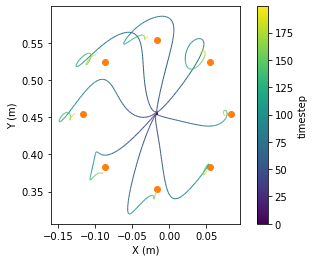

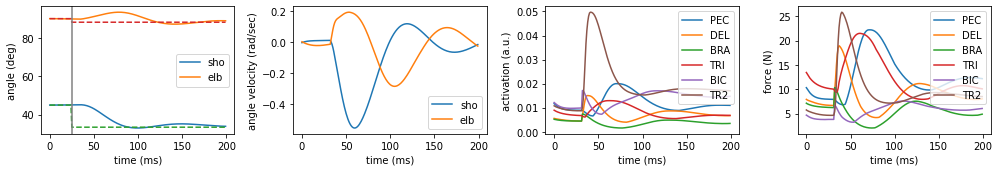

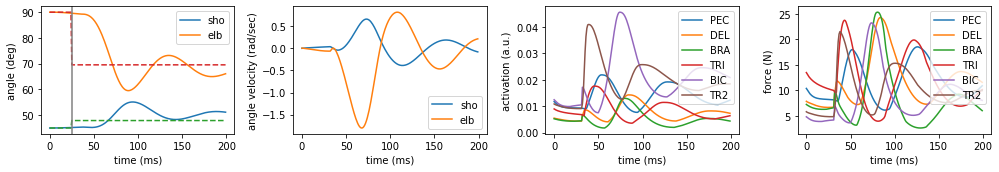

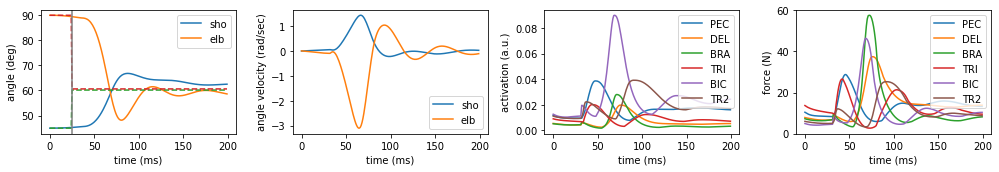

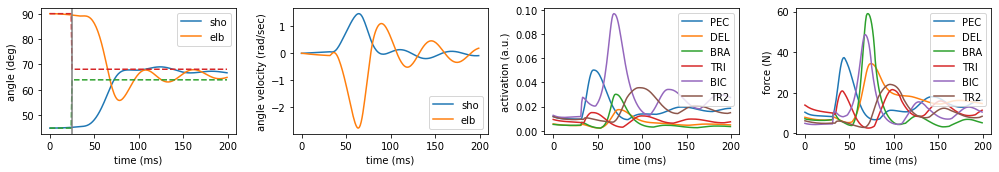

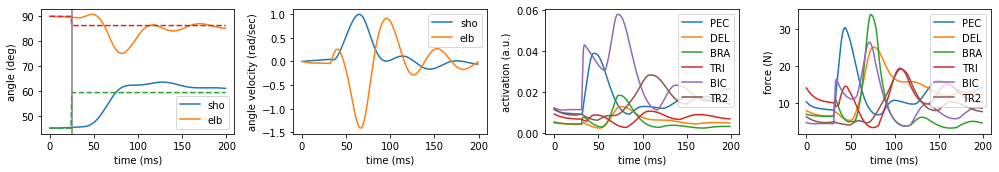

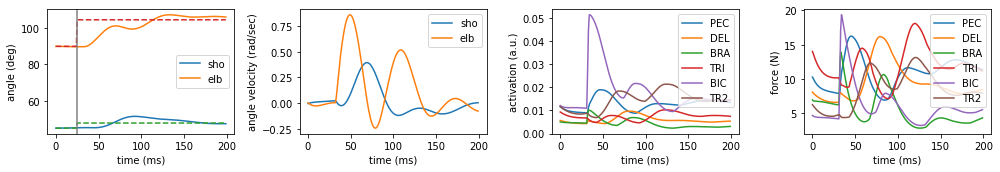

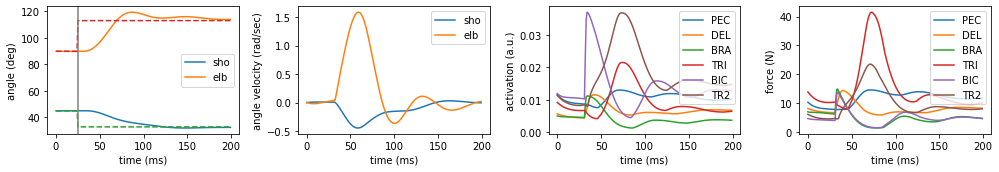

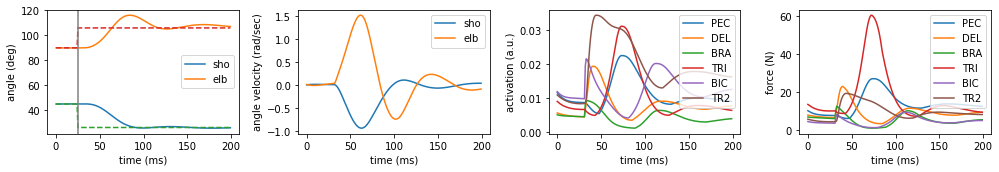

In [10]:
# TEST THE NETWORK ON THE CENTRE-OUT REACHING TASK
# IN A CW CURL FIELD

FF = FF_CW

nn.task.angle_step = 45
n_t = 200
[inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=8, centre_out_test=True)
nn.task.FF_matvel = FF
results = nn([inputs, init_states], training=False)

plot_simulations(xy=results["cartesian position"], target_xy=targets)

L1,L2 = nn.task.network.plant.skeleton.L1, nn.task.network.plant.skeleton.L2
targets_j = hand_to_joints(targets, L1, L2)
n_mov = np.shape(results["joint position"])[0]
for i in range(n_mov):
    plot1trial(inputs, results, targets_j, i)

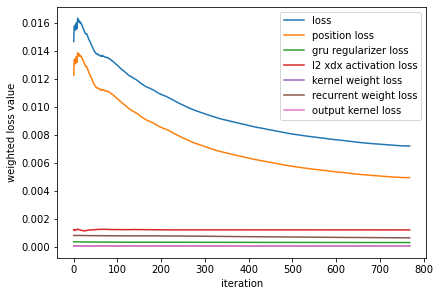

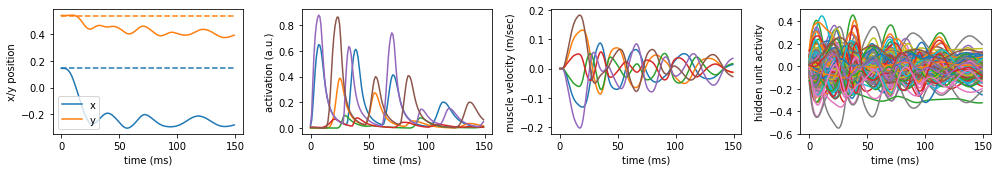

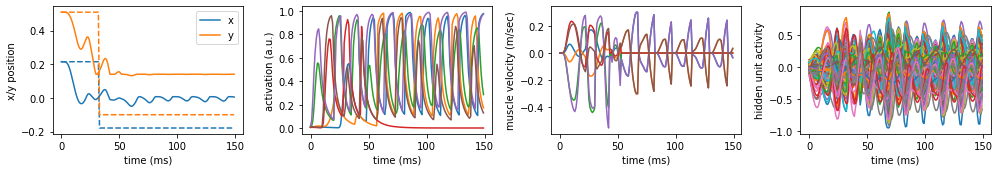

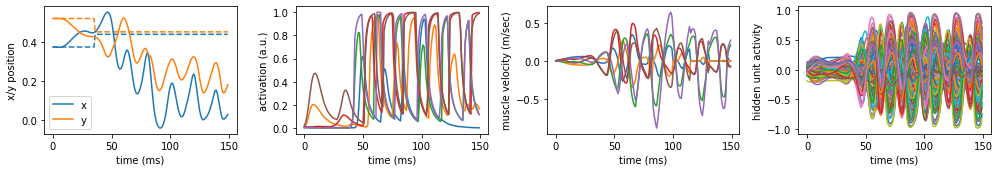

1024/1024 [==============================] - 153s 144ms/step - loss: 0.0067 - position_loss: 0.0090 - gru_regularizer_loss: 0.0028 - l2_xdx_activation_loss: 1.1780e-04


In [11]:
# TRAIN NETWORK on centre-out task
# IN A CCW FF

FF = FF_CCW

nn.task.angle_step = 45
batch_size = 8

n_t = 150
n_batches = 2**10
# this callback logs training information for each batch passed, rather than for each epoch.
callbacks = [mn.nets.callbacks.BatchLogger(), mn.nets.callbacks.TrainingPlotter(task, plot_freq=256, plot_trials=3, plot_n_t=n_t)]
for i in range(1):
    [inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=batch_size*n_batches, centre_out_test=True)
    nn.task.FF_matvel = FF
    h = nn.fit(x=[inputs, init_states], y=targets, verbose=1, epochs=1, batch_size=batch_size, shuffle=False, callbacks=callbacks)

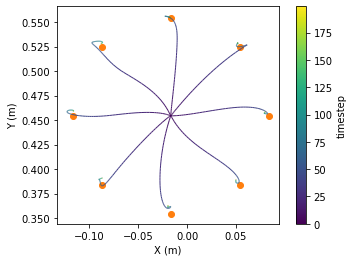

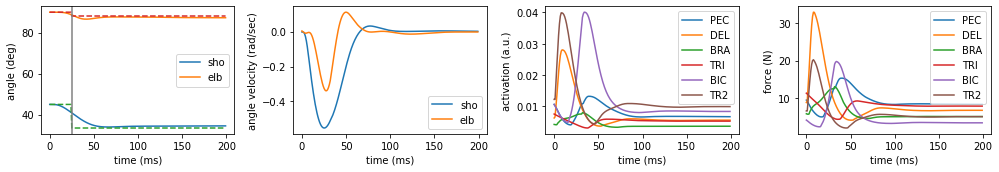

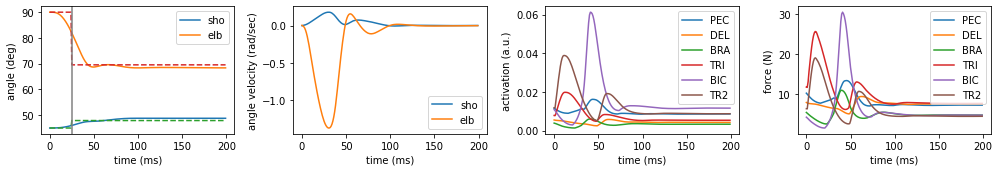

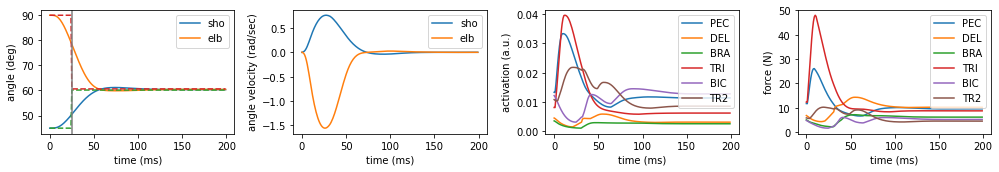

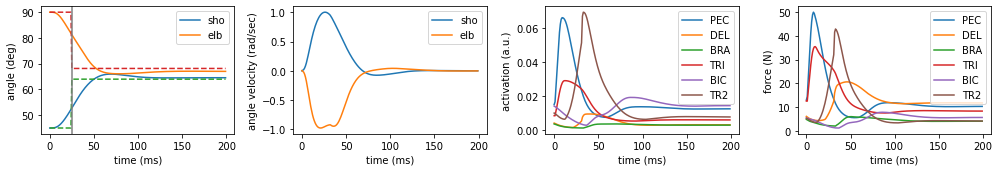

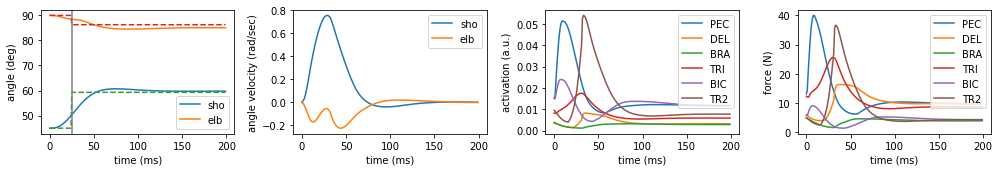

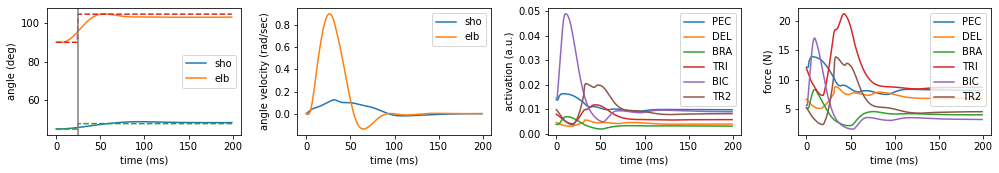

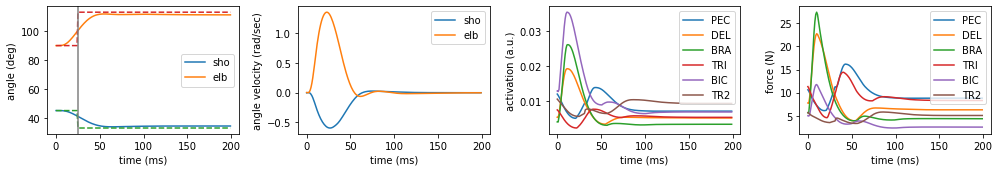

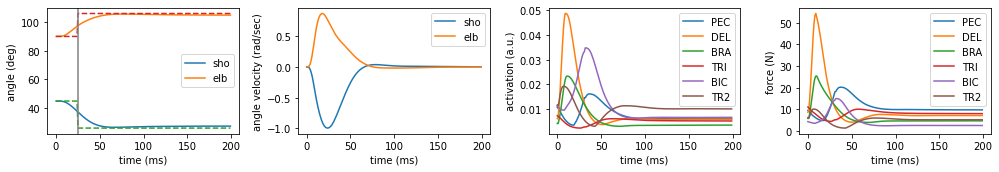

In [12]:
# TEST THE NETWORK ON THE CENTRE-OUT REACHING TASK
# IN A CCW CURL FIELD

FF = FF_CCW

nn.task.angle_step = 45
n_t = 200
[inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=8, centre_out_test=True)
nn.task.FF_matvel = FF
results = nn([inputs, init_states], training=False)

plot_simulations(xy=results["cartesian position"], target_xy=targets)

L1,L2 = nn.task.network.plant.skeleton.L1, nn.task.network.plant.skeleton.L2
targets_j = hand_to_joints(targets, L1, L2)
n_mov = np.shape(results["joint position"])[0]
for i in range(n_mov):
    plot1trial(inputs, results, targets_j, i)

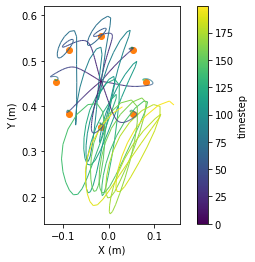

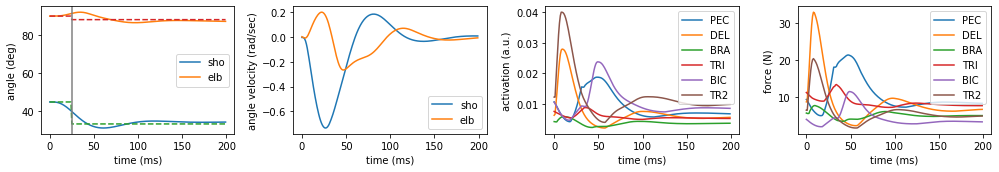

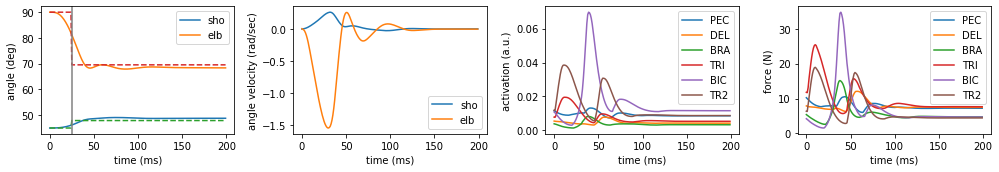

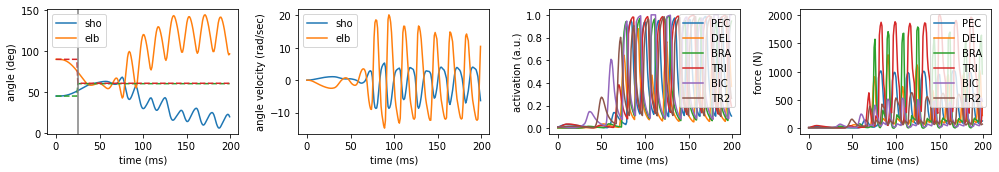

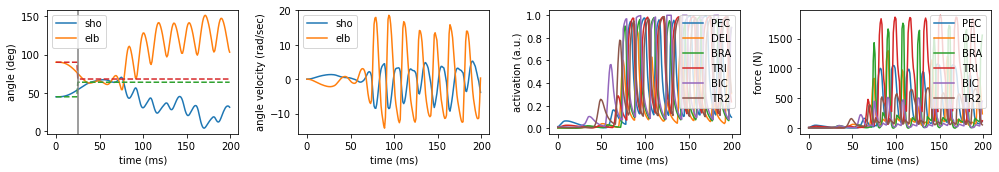

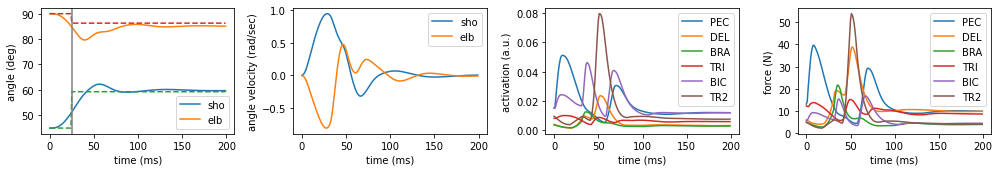

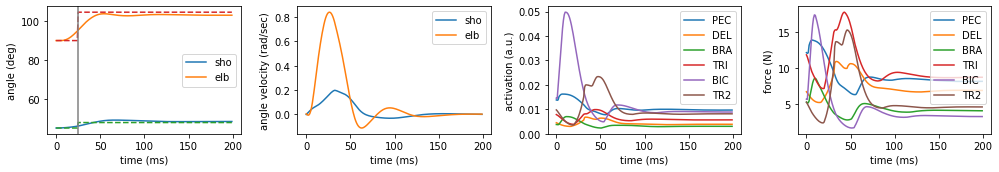

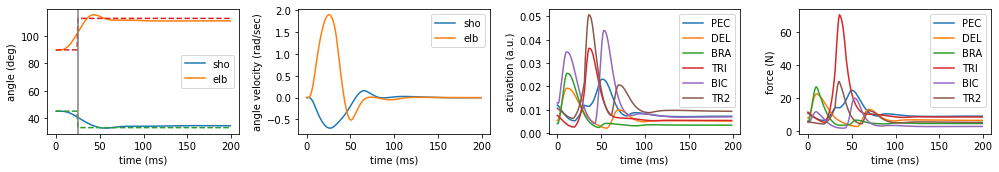

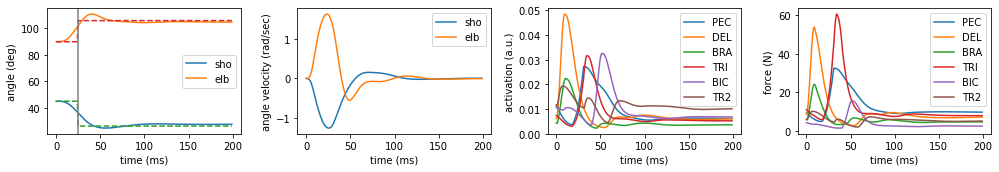

In [13]:
# TEST THE NETWORK ON THE CENTRE-OUT REACHING TASK
# IN A NULL FIELD

FF = FF_NF

n_t = 200
nn.task.angle_step = 45
[inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=8, centre_out_test=True)
nn.task.FF_matvel = FF
results = nn([inputs, init_states], training=False)

plot_simulations(xy=results["cartesian position"], target_xy=targets)

L1,L2 = nn.task.network.plant.skeleton.L1, nn.task.network.plant.skeleton.L2
targets_j = hand_to_joints(targets, L1, L2)
n_mov = np.shape(results["joint position"])[0]
for i in range(n_mov):
    plot1trial(inputs, results, targets_j, i)